In [46]:
import numpy as np
import matplotlib.pyplot as plt

def rk2_step(f,y,h,t):
    k1 = h * f(t, y)
    k2 = h * f(t + h, y + k1)
    return y + 0.5 * (k1 + k2)

def rk3_step(f, y, h, t):
    k1 = h * f(t, y)
    k2 = h * f(t + 0.5 * h, y + 0.5 * k1)
    k3 = h * f(t + h, y - k1 + 2 * k2)
    return y + (1/6) * (k1 + 4 * k2 + k3)

def adaptive_step(f, y0, t0, t_end, h_init, rtol = 1e-4, atol=1e-6):
    """
    Solves an ODE using adaptive step size with RK2 and Euler methods.

    Parameters:
    f: function - The derivative function dy/dt = f(t, y)
    y0: float or ndarray - Initial value
    t0: float - Initial time
    t_end: float - Final time
    h_init: float - Initial step size


    Returns:
    t_values: list - List of time values
    y_values: list - List of solution values
    """
    t_values = [t0]
    y_values = [y0]
    t = t0
    y = y0
    h = h_init
    count = 0
    while t < t_end:
        count += 1
        if t + h > t_end:
            h = t_end - t  # Adjust step size for the last step

        # Euler's method (first-order approximation)
        y_rk3 = rk3_step(f,y,h,t)

        # RK2 method (second-order approximation)
        y_rk2 = rk2_step(f,y,h,t)

        # Estimate error as the difference between RK2 and Euler's method
        error = np.abs(y_rk3 - y_rk2)

        tol = rtol*np.max(np.abs(y_rk3)) + atol
        # Check if error is within tolerance
        if error < tol:
            t += h
            y = y_rk3
            t_values.append(t)
            y_values.append(y)

        # Adjust step size based on error estimate
        h *= 0.9 * (tol / (error + 1e-10))**(1/3)  
    print('Number of error estimates:',count)
    return np.array(t_values), np.array(y_values)


# Example usage
def u_x(t, y):
    return y**2-y**3


delta = 0.02
t0, t_end, y0, h_init = 0, 2/delta, delta, 0.1
t_values, y_values = adaptive_step(u_x, y0, t0, t_end, h_init)

print(len(t_values))

Number of error estimates: 102
100


# Analytical solution 

In [47]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the same function
def u_x(t, y):
    return y**2 - y**3

# Parameters
delta = 0.02
t0, t_end, y0 = 0, 2/delta, delta

# Solve using solve_ivp
sol = solve_ivp(u_x, [t0, t_end], [y0], method='RK45', rtol=1e-4, atol=1e-6, dense_output=True)

def implicit_y_scalar(t, delta):
    y_min=delta
    y_max=1
    def f(y):
        if y <= 0 or y >= 1:
            return np.inf
        try:
            term1 = np.log((y * (1 - delta)) / (delta * (1 - y)))
            term2 = (y - delta) / (y * delta)
            return term1 + term2 - t
        except:
            return np.inf

    # Find bracket with sign change
    y_vals = np.linspace(y_min, y_max, 1000)
    f_vals = [f(y) for y in y_vals]

    for i in range(len(f_vals) - 1):
        if np.sign(f_vals[i]) != np.sign(f_vals[i + 1]):
            bracket = (y_vals[i], y_vals[i + 1])
            break
    else:
        return np.nan  # No root found

    sol = root_scalar(f, bracket=bracket, method='brentq', xtol=1e-8)
    if sol.converged:
        return sol.root
    else:
        return np.nan

def implicit_y(t_array, delta):
    # Vectorized wrapper
    t_array = np.atleast_1d(t_array)
    return np.array([implicit_y_scalar(ti, delta) for ti in t_array])


Number of error estimates: 102
Number of error estimates: 5191


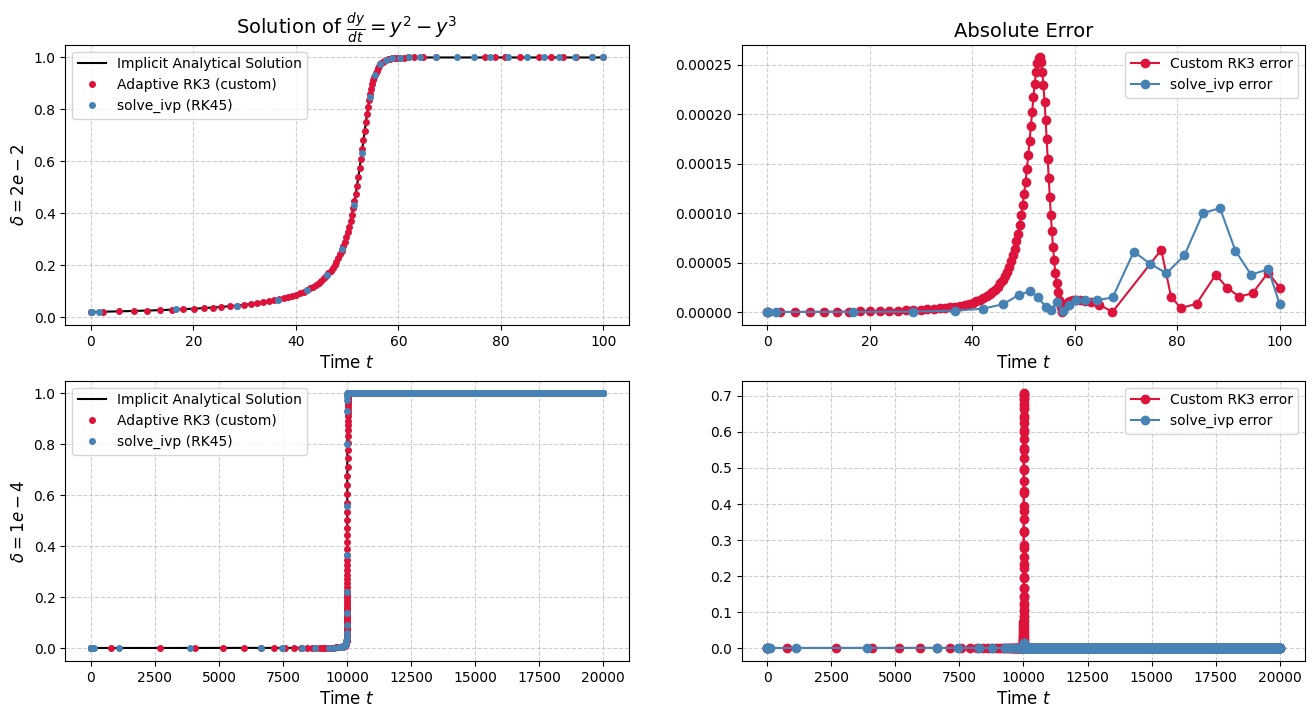

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), dpi=100)
for i, delta in  enumerate([0.02, 1e-4]):
    t0, t_end, y0, h_init = 0, 2/delta, delta, 0.1
    t_values, y_values = adaptive_step(u_x, y0, t0, t_end, h_init)
    # Solve using solve_ivp
    sol = solve_ivp(u_x, [t0, t_end], [y0], method='RK45', rtol=1e-4, atol=1e-6, dense_output=True)

    # refernece solution using implicit analytical solution
    t_ref = np.linspace(t0, t_end, 3000)
    y_ref = implicit_y(t_ref, delta)

    # First subplot: solutions
    axs[i,0].plot(t_ref, y_ref, '-', label = 'Implicit Analytical Solution',color = 'black')
    axs[i,0].plot(t_values, y_values, 'o', label='Adaptive RK3 (custom)', color='crimson', markersize=4)
    axs[i,0].plot(sol.t, sol.y[0], 'o', label='solve_ivp (RK45)', color='steelblue', markersize=4)
    axs[i,0].set_xlabel('Time $t$', fontsize=12)
    if i==0:
        axs[i,0].set_ylabel(r'$\delta = 2e-2$', fontsize=12)
        axs[i,0].set_title(r'Solution of $\frac{dy}{dt} = y^2 - y^3$', fontsize=14)
    else:
        axs[i,0].set_ylabel(r'$\delta = 1e-4$', fontsize=12)
    axs[i,0].grid(True, linestyle='--', alpha=0.6)
    axs[i,0].legend()

    # Second subplot: absolute error
    axs[i,1].plot(t_values, abs(implicit_y(t_values, delta) - y_values),
                '-o', label='Custom RK3 error',color='crimson')
    axs[i,1].plot(sol.t, abs(implicit_y(sol.t, delta) - sol.y[0]), 
                '-o', label='solve_ivp error',color='steelblue')
    axs[i,1].set_xlabel('Time $t$', fontsize=12)
    if i==0:
        axs[i,1].set_title('Absolute Error', fontsize=14)
    axs[i,1].grid(True, linestyle='--', alpha=0.6)
    axs[i,1].legend()


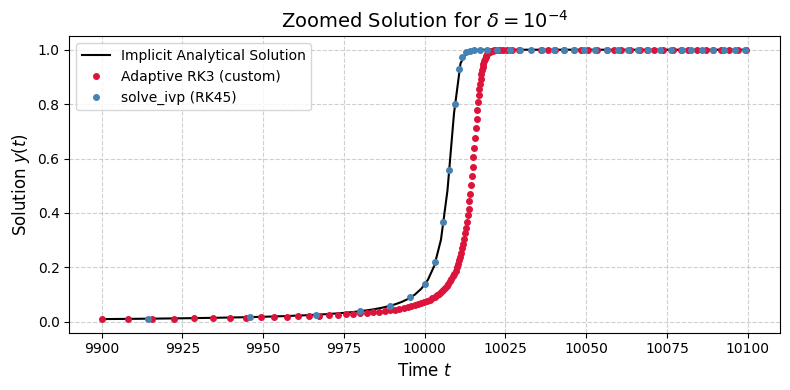

In [49]:
# Zoom range around t = 10000
t_zoom_min = 9900
t_zoom_max = 10100

# zoomed reference
t_ref = np.linspace(t_zoom_min, t_zoom_max, 100)
y_ref = implicit_y(t_ref, delta)
# Create new figure for zoomed-in solution
plt.figure(figsize=(8, 4), dpi=100)

# Mask values within zoom range
mask_ref = (t_ref >= t_zoom_min) & (t_ref <= t_zoom_max)
mask_rk3 = (t_values >= t_zoom_min) & (t_values <= t_zoom_max)
mask_ivp = (sol.t >= t_zoom_min) & (sol.t <= t_zoom_max)

# Plot zoomed solutions
plt.plot(t_ref[mask_ref], implicit_y(t_ref[mask_ref], 1e-4), '-', color='black', label='Implicit Analytical Solution')
plt.plot(t_values[mask_rk3], y_values[mask_rk3], 'o', color='crimson', label='Adaptive RK3 (custom)', markersize=4)
plt.plot(sol.t[mask_ivp], sol.y[0][mask_ivp], 'o', color='steelblue', label='solve_ivp (RK45)', markersize=4)

plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('Solution $y(t)$', fontsize=12)
plt.title(r'Zoomed Solution for $\delta = 10^{-4}$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
